# Stochastic Gradient Descent

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [2]:
from sklearn import model_selection

data = pd.read_csv("w8a.csv", sep=";", header=None)

X = data.iloc[:,:-1].to_numpy()
y = data.iloc[:,-1].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=32)

## Logistic Regression



Today we'll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [3]:
#TODO
from sklearn.linear_model import LogisticRegression
reg_log = LogisticRegression(penalty='l2')
reg_log.fit(X_train, y_train)
y_predict = reg_log.predict(X_test)

and we compute the accuracy score to evaluate the model performance:

In [4]:
#TODO
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"Accuracy : {accuracy_score(y_test, y_predict)}")
print(f"Precision : {precision_score(y_test, y_predict)}")
print(f"Recall : {recall_score(y_test, y_predict)}")
print(f"F1-score : {f1_score(y_test, y_predict)}")

Accuracy : 0.9836764526738945
Precision : 0.8888888888888888
Recall : 0.5692883895131086
F1-score : 0.6940639269406392


### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

class StochasticLogisticRegression(BaseEstimator, ClassifierMixin):
    """Class for logistic regression:

    Attributes:
    -----------                                                                              Default value
    coef_         : 1-dimensional np.array, coefficients / weights                         | None
    lambd_        : float,                  regularization parameter                       | 0.1
    penalty_      : string,                 the type of regularization                     | 'l1'
    lr_           : float,                  the learning rate                              | 0.01
    bsize         : integer,                the size of the mini-batch >=1                 | 64
    gamma         : float,                  gamma coefficient                              | 0.999
    beta          : float,                  beta coefficient                               | 0.9
    eps           : float,                  epsilon coefficient                            | 10-8
    debias        : boolean,                indicates if we use the debiais correction     | False
    coef_history_ : list,                   the list of all visited betas/ weights         | []
    f_history_    : list ,                  the list of all evaluations in visited betas   | []
    thresh        : float,                  decision threshold for classification          | 0.5
    """

    def __init__(
        self,
        lambd=0.1,
        penalty="l1",
        lr=1e-2,
        batchsize=64,
        opt="Vanilla",
        gamma=0.999,
        beta=0.9,
        eps=1e-8,
        debias=False,
        calculate_cost=False,
        thresh=0.5,
    ):
        self.coef_ = None  # weights
        self.lambd = lambd
        self.penalty= penalty
        self.lr = lr
        self.batchsize = batchsize
        self.opt = opt
        self.gamma = gamma
        self.beta = beta
        self.eps = eps
        self.debias = debias
        self.coef_history_ = []
        self.f_history_ = []
        self.thresh = thresh
        self.calculate_cost = calculate_cost

    def logistic(self, z):
        """_summary_

        Args:
            z (_type_): _description_
        """
        # TODO
        return np.log(1 + np.exp(z))

    def loss_function(self, X, y):
        """_summary_

        Args:
            X (_type_): _description_
            y (_type_): _description_
        """
        # TODO
        if self.penalty== "l1":
            return np.sum(
                self.logistic(np.diag(-y.flatten()) @ X @ self.coef_)
                )+ self.lambd * np.linalg.norm(self.coef_, 1)
        elif self.penalty== "l2":
            return np.sum(
                self.logistic(np.diag(-y.flatten()) @ X @ self.coef_)
                ) + self.lambd * np.linalg.norm(self.coef_, 2)
        else:
            return np.sum(
                self.logistic(np.diag(-y.flatten()) @ X @ self.coef_)
                )

    def sigmoid(self, z):
        """_summary_

        Args:
            z (_type_): _description_
        """
        # TODO
        return 1 / (1 + np.exp(-z))

    def soft_threshold(self, val, alpha_):
        """Pour la pénalisation l1

        Args:
            val (_type_): _description_
            alpha_ (_type_): _description_

        Returns:
            _type_: _description_
        """
        return np.sign(val) * np.maximum(np.abs(val) - alpha_, 0)

    def fit(self, X, y, max_iter=100):
        """Fit the data (X, y).

        Parameters:
        -----------                                                                         Default value
        X          : (num_samples, num_features) np.array, Design matrix                  |
        y          : (num_sampes, ) np.array,              Output vector                  |
        max_iter   : integer,                              the number of epochs           | 100
        mini_batch : bool,                                 method used                    | False
        """
        # TODO
        # Rajout de l'intercept
        X = np.c_[np.ones(X.shape[0]), X]
        # Initalisation des coefficients de manière aléatoire
        coef = np.zeros(X.shape[1]).reshape(-1, 1)
        m = 0
        grads_saga = []

        if self.opt == "Vanilla" or self.opt == "Momentum" or self.opt == "SAGA":
            s = 1
        else:
            s = 0

        for epoch in tqdm(range(max_iter)):
            # Tirage aléatoire de bsize indices
            idx = np.random.choice(X.shape[0], self.batchsize)
            X_batch = X[idx]
            y_batch = y[idx]
            L = np.diag(-y_batch.flatten()) @ X_batch
            # Calcul du gradient
            if self.penalty == "l2":
                grad = L.T @ self.sigmoid(L @ coef).reshape(-1, 1) + self.lambd * coef
            else:
                grad = L.T @ self.sigmoid(L @ coef).reshape(-1, 1)

            # TODO
            # Mise à jour des coefficients en fonction de l'optimiseur
            if self.opt == "Vanilla":
                coef = coef - (self.lr / (np.sqrt(s + self.eps))) * grad
            elif self.opt == "Adagrad":
                s += np.linalg.norm(grad, 2) ** 2
                coef = coef - (self.lr / (np.sqrt(s + self.eps))) * grad
            elif self.opt == "RMSprop":
                s = self.gamma * s + (1 - self.gamma) * np.linalg.norm(grad, 2) ** 2
                coef = coef - (self.lr / (np.sqrt(s + self.eps))) * grad
            elif self.opt == "Momentum":
                m = self.beta * m + self.lr * grad
                coef = coef - (1 / (np.sqrt(s + self.eps))) * m 
            elif self.opt == "SAGA":
                grads_saga.append(grad)
                coef = coef - (self.lr / (np.sqrt(s + self.eps))) * np.mean(grads_saga)
            elif self.opt == "ADAM":
                if self.debias:
                    m = self.beta * m + (1 - self.beta) * grad
                    s = (
                        self.gamma * s
                        + (1 - self.gamma) * np.linalg.norm(grad, 2) ** 2
                    )
                    m = m / (1 - self.beta**epoch)
                    s = s / (1 - self.gamma**epoch)
                else:
                    m = self.beta * m + (1 - self.beta) * grad
                    s = (
                        self.gamma * s
                        + (1 - self.gamma) * np.linalg.norm(grad, 2) ** 2
                    )
                coef = coef - (self.lr / (np.sqrt(s + self.eps))) * m 

            # Sauvegarde des coefficients et de la fonction de coût
            if self.penalty == "l1":
                coef = self.soft_threshold(coef, self.lambd * self.lr)

            self.coef_ = coef
            self.coef_history_.append(coef)
        

        if self.calculate_cost:
            # Une fois les coefs enregistrés, on calcule la fonction de coût pour chaque beta
            z = np.diag(-y.flatten()) @ X @ np.array(self.coef_history_).T
            logistic_loss = np.mean(np.log(1 + np.exp(z)), axis=1)  # Mean across samples for each beta
            self.f_history_ = logistic_loss[0].tolist()

    def plot_costs(self):
        """Plot the history of the cost function."""
        # Utiliser les index de self.f_history_ directement comme abscisses
        plt.plot(list(range(len(self.f_history_))), self.f_history_)
        plt.xlabel("Iterations")
        plt.ylabel("Cost function")
        plt.title("Cost function over iterations")
        plt.show()

    def predict_probas(self, X):
        """Make binary predictions for data X.

        Parameters:
        -----------
        X: (num_samples, num_features) np.array, Design matrix

        Returns:
        -----
        y_pred: (num_samples, ) np.array, Predictions in probability
        """
        # TODO
        X = np.c_[np.ones(X.shape[0]), X]
        probas = self.sigmoid(X @ self.coef_)
        return probas
    
    def predict(self, X):
        """Make binary predictions for data X.

        Parameters:
        -----------
        X: (num_samples, num_features) np.array, Design matrix

        Returns:
        -----
        y_pred: (num_samples, ) np.array, Predictions in {0, 1}
        """
        # TODO
        probas = self.predict_probas(X)
        return np.where(probas > self.thresh, 1, -1)

    def accuracy_evaluation(self, X, y, thresh=0.5, margin=0, vizualisation=True):
        """Compute detailed accuracy rates.

        Parameters:
        -----------                                                              Default value
        X                : (num_samples, num_features) np.array, Input data    |
        y                : (num_samples, ) np.array, Labels of the input data  |
        thresh           : Decision threshold                                  | 0.5
        margin           : If the prediction is at a distance less than margin | 0
                           to the treshold, returns undetermined label.        |
        vizualisation    : Allow the user to vizualize in a board the results  | True

        Returns:
        -----
        good_prediction  : % of correct classifications
        undetermined     : % of indetermined labels
        wrong_prediction : % of wrong classifications
        TP               : % of 1 labelled 1
        UP               : % of 1 labelled undetermined
        FN               : % of 1 labelled 0
        TN               : % of 0 labelled 0
        UN               : % of 0 labelled undetermined
        FP               : % of 0 labelled 1
        F1_score         : F1-score
        """
        # TODO
        probas = self.predict_probas(X)
        y_pred = np.where(probas > thresh, 1, -1)
        y = y.reshape(-1, 1)
        good_prediction = np.mean(y_pred == y)
        undetermined = np.mean(np.abs(probas - thresh) < margin)
        wrong_prediction = 1 - good_prediction - undetermined
        TP = np.mean((y_pred == 1) & (y == 1))
        UP = np.mean((y == 1) & (np.abs(probas - thresh) < margin))
        FN = np.mean((y_pred == -1) & (y == 1))
        TN = np.mean((y_pred == -1) & (y == -1))
        UN = np.mean((y == -1) & (np.abs(probas - thresh) < margin))
        FP = np.mean((y_pred == 1) & (y == -1))
        F1_score = (2 * TP ) / (2 * TP + FP + FN)
        if vizualisation:
            # plot the confusion matrix
            confusion_matrix = metrics.confusion_matrix(y, y_pred)
            sns.heatmap(confusion_matrix, annot=True)
            plt.show()
        return {
            "good_prediction": good_prediction,
            "undetermined": undetermined,
            "wrong_prediction": wrong_prediction,
            "TP": TP,
            "UP": UP,
            "FN": FN,
            "TN": TN,
            "UN": UN,
            "FP": FP,
            "F1_score": F1_score,
        }

    def find_thresh(self, X, y, step=0.01, margin=0):
        """Find the decision threshsold that maximize the f1_score

        Parameters:
        -----------                                                    Default value
        X      : (num_samples, num_features) np.array, Input data    |
        y      : (num_samples, ) np.array, Labels of the input data  |
        step   : Decision threshold                                  | 0.01
        margin : If the prediction is at a distance less than margin | 0
                 to the treshold, returns undetermined label.        |
        """
        # TODO
        f1_scores = []
        for thresh in tqdm(np.arange(0, 1, step)):
            f1_scores.append(
                self.accuracy_evaluation(X, y, thresh, margin, False)["F1_score"]
            )

        # Plot des résultats
        plt.plot(np.arange(0, 1, step), f1_scores)
        plt.xlabel("Threshold")
        plt.ylabel("F1-score")
        plt.title("F1-score en fonction du threshold")
        plt.show()
        best_thresh = np.arange(0, 1, step)[np.argmax(f1_scores)]
        print(f"Best F1-score : {np.max(f1_scores)}")
        return best_thresh

In [6]:
# Jeu sur les paramètres 
# TODO
# Initialisation des paramètres
lambd = 0.1
penalty = "l2"
lr = 1e-3
batchsize = 64
opt = "Momentum"
gamma = 0.999
beta = 0.9
eps = 1e-8
debias = False
thresh = 0.5
calculate_cost = True

SBD_logreg = StochasticLogisticRegression(
    lambd=lambd,
    penalty=penalty,
    lr=lr,
    batchsize=batchsize,
    opt=opt,
    gamma=gamma,
    beta=beta,
    eps=eps,
    debias=debias,
    thresh=thresh,
    calculate_cost=calculate_cost,
)

100%|██████████| 1000/1000 [00:00<00:00, 2674.35it/s]


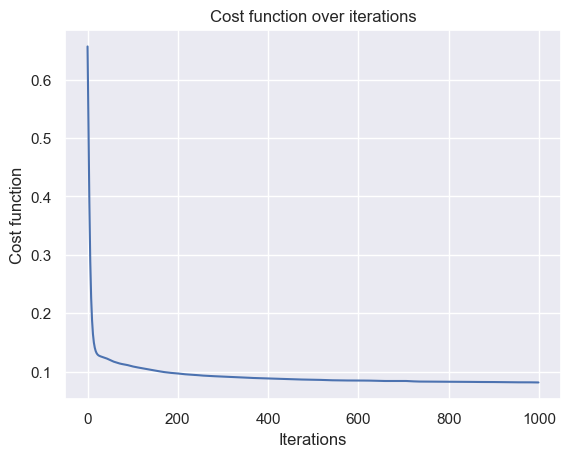

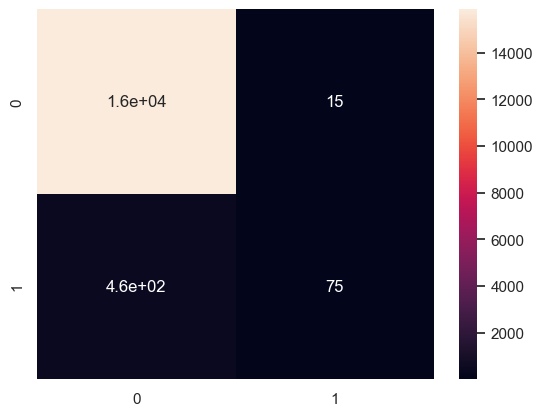

{'good_prediction': 0.9711292483859179, 'undetermined': 0.0, 'wrong_prediction': 0.028870751614082146, 'TP': 0.004568156900962358, 'UP': 0.0, 'FN': 0.027957120233889632, 'TN': 0.9665610914849555, 'UN': 0.0, 'FP': 0.0009136313801924717, 'F1_score': 0.2403846153846154}


In [7]:
SBD_logreg.fit(X_train, y_train, max_iter=1000)
SBD_logreg.plot_costs()
print(SBD_logreg.accuracy_evaluation(X_test,y_test,thresh=0.5,margin=0,vizualisation=True))

Apply to the data

On essaie plusieurs entraînements avec différents coefficients de régularisation, on choisit celui qui minimise
l'erreur sur le test set. On entraine sur 1000 itérations en batch gradient descent. On garde **lambda = 0.01**.
On essaie ensuite plusieurs learning rates, on choisit le plus grand qui permet d'obtenir un gradient qui converge. On garde **lr = 0.01**.

In [8]:
liste_lambd = [0.01, 0.1, 1, 2, 10]
penalty = "l2"
lr = 1e-2
batchsize = 64
opt = "Momentum"
gamma = 0.999
beta = 0.9
eps = 1e-8
debias = False
thresh = 0.1
calculate_cost = False

for lambd in tqdm(liste_lambd) :
    SBD_logreg = StochasticLogisticRegression(
    lambd=lambd,
    penalty=penalty,
    lr=lr,
    batchsize=batchsize,
    opt=opt,
    gamma=gamma,
    beta=beta,
    eps=eps,
    debias=debias,
    thresh=thresh,
    calculate_cost=calculate_cost,
)
    SBD_logreg.fit(X_train, y_train, max_iter=100)
    print(f"Lambda : {lambd}")
    print(SBD_logreg.accuracy_evaluation(X_test,y_test,thresh=0.5,margin=0,vizualisation=False))

100%|██████████| 100/100 [00:00<00:00, 2462.40it/s]


Lambda : 0.01
{'good_prediction': 0.9738701425264953, 'undetermined': 0.0, 'wrong_prediction': 0.026129857473504714, 'TP': 0.00901449628456572, 'UP': 0.0, 'FN': 0.02351078085028627, 'TN': 0.9648556462419295, 'UN': 0.0, 'FP': 0.002619076623218419, 'F1_score': 0.4082758620689655}


 40%|████      | 2/5 [00:00<00:00,  9.21it/s]

Lambda : 0.1
{'good_prediction': 0.9710074308685589, 'undetermined': 0.0, 'wrong_prediction': 0.028992569131441104, 'TP': 0.00450724814228286, 'UP': 0.0, 'FN': 0.02801802899256913, 'TN': 0.966500182726276, 'UN': 0.0, 'FP': 0.0009745401388719698, 'F1_score': 0.2371794871794872}


 60%|██████    | 3/5 [00:00<00:00,  9.12it/s]

Lambda : 1
{'good_prediction': 0.9685101717626995, 'undetermined': 0.0, 'wrong_prediction': 0.03148982823730051, 'TP': 0.0010354488975514678, 'UP': 0.0, 'FN': 0.031489828237300524, 'TN': 0.967474722865148, 'UN': 0.0, 'FP': 0.0, 'F1_score': 0.0617059891107078}


100%|██████████| 100/100 [00:00<00:00, 830.75it/s]

Lambda : 2



 80%|████████  | 4/5 [00:00<00:00,  7.00it/s]

{'good_prediction': 0.967474722865148, 'undetermined': 0.0, 'wrong_prediction': 0.03252527713485198, 'TP': 0.0, 'UP': 0.0, 'FN': 0.03252527713485199, 'TN': 0.967474722865148, 'UN': 0.0, 'FP': 0.0, 'F1_score': 0.0}


100%|██████████| 100/100 [00:00<00:00, 1150.33it/s]


Lambda : 10


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]

{'good_prediction': 0.967474722865148, 'undetermined': 0.0, 'wrong_prediction': 0.03252527713485198, 'TP': 0.0, 'UP': 0.0, 'FN': 0.03252527713485199, 'TN': 0.967474722865148, 'UN': 0.0, 'FP': 0.0, 'F1_score': 0.0}


 83%|████████▎ | 5/6 [01:01<00:11, 11.59s/it]C:\Users\victo\AppData\Local\Temp\ipykernel_9112\2474428468.py:88: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
100%|██████████| 100/100 [00:00<00:00, 857.96it/s]
C:\Users\victo\AppData\Local\Temp\ipykernel_9112\2474428468.py:181: RuntimeWarning: overflow encountered in exp
  logistic_loss = np.mean(np.log(1 + np.exp(z)), axis=1)  # Mean across samples for each beta
100%|██████████| 6/6 [01:11<00:00, 11.91s/it]


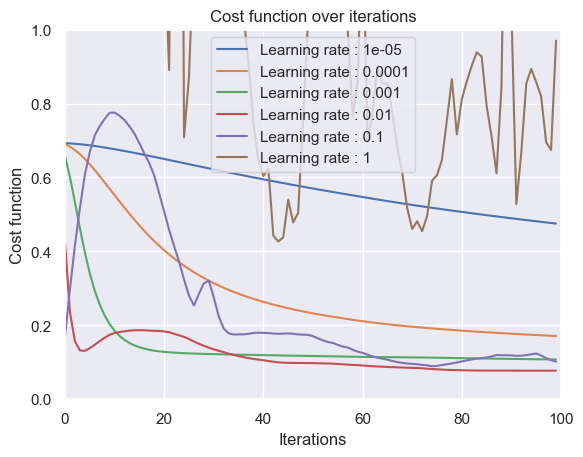

In [9]:
lambd = 0.01
penalty = "l2"
lrs = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1]
batchsize = 64
opts = "Momentum"
gammas = 0.999
beta = 0.9
eps = 1e-8
debias = False
thresh = 0.1
calculate_cost = True

courbes_costs_lr = []

for lr in tqdm(lrs):
    SBD_logreg = StochasticLogisticRegression(
        lambd=lambd,
        penalty=penalty,
        lr=lr,
        batchsize=batchsize,
        opt=opt,
        gamma=gamma,
        beta=beta,
        eps=eps,
        debias=debias,
        thresh=thresh,
        calculate_cost=calculate_cost,
    )
    SBD_logreg.fit(X_train, y_train, max_iter=100)
    courbes_costs_lr.append(SBD_logreg.f_history_)

# Plot costs
for i, courbe in enumerate(courbes_costs_lr):
    plt.plot(list(range(len(courbe))), courbe, label=f"Learning rate : {lrs[i]}")
plt.xlabel("Iterations")
plt.xlim(0, 100)
plt.ylabel("Cost function")
plt.ylim(0, 1)
plt.title("Cost function over iterations")
plt.legend()
plt.show()

## Optimal threshold

100%|██████████| 10/10 [00:00<00:00, 32.81it/s]


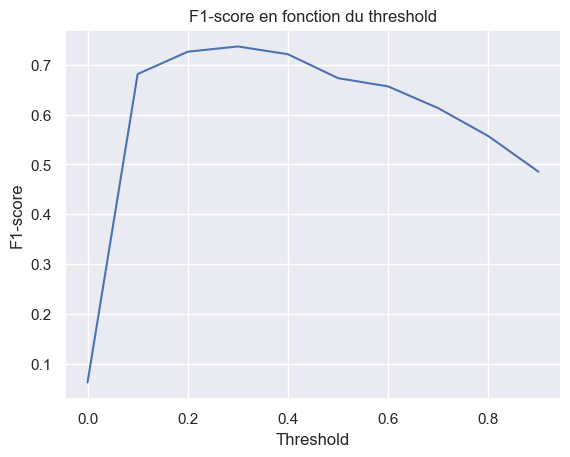

Best F1-score : 0.7364016736401675


0.30000000000000004

In [10]:
#TODO
# 0.3 appears as the best threshold

lambd = 0.01
penalty = "l2"
lr = 1e-3
batchsize = 1024
opt = "Momentum"
gamma = 0.999
beta = 0.9
eps = 1e-8
debias = False
thresh = 0.5
calculate_cost = False

SBD_logreg = StochasticLogisticRegression(
    lambd=lambd,
    penalty=penalty,
    lr=lr,
    batchsize=batchsize,
    opt=opt,
    gamma=gamma,
    beta=beta,
    eps=eps,
    debias=debias,
    thresh=thresh,
    calculate_cost=calculate_cost,
)

SBD_logreg.fit(X_train, y_train, max_iter=1000)
SBD_logreg.find_thresh(X_test, y_test, step=0.1, margin=0)

## Training of the model

100%|██████████| 2/2 [00:24<00:00, 12.08s/it]


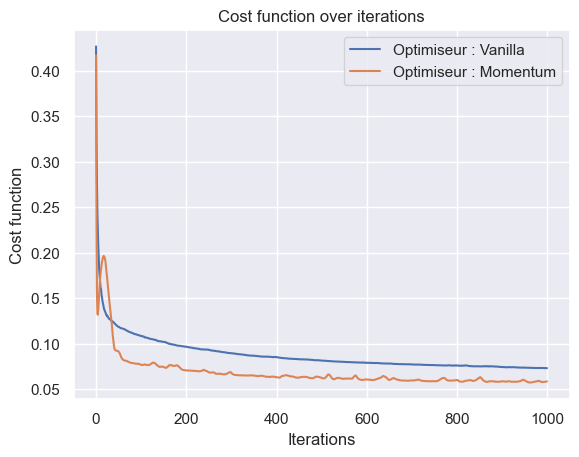

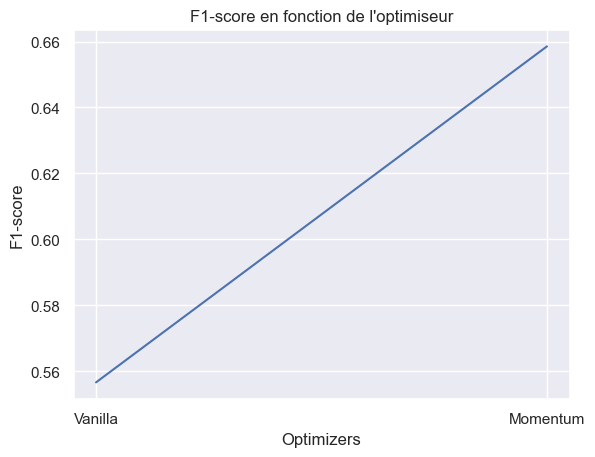

In [11]:
lambd = 0.01
penalty = "l2"
lr = 1e-2
batchsize = 64
opts = ["Vanilla", "Momentum"]
gammas = 0.999
beta = 0.9
eps = 1e-8
debias = False
thresh = 0.2
calculate_cost = True

courbes_costs_opt = []
f1_scores_opt = []

for opt in tqdm(opts):
    SBD_logreg = StochasticLogisticRegression(
        lambd=lambd,
        penalty=penalty,
        lr=lr,
        batchsize=batchsize,
        opt=opt,
        gamma=gamma,
        beta=beta,
        eps=eps,
        debias=debias,
        thresh=thresh,
        calculate_cost=calculate_cost,
    )
    SBD_logreg.fit(X_train, y_train, max_iter=1000)
    courbes_costs_opt.append(SBD_logreg.f_history_)
    f1_scores_opt.append(SBD_logreg.accuracy_evaluation(X_test,y_test,thresh=0.1,margin=0,vizualisation=False)['F1_score'])

# Plot costs
for i, courbe in enumerate(courbes_costs_opt):
    plt.plot(list(range(len(courbe))), courbe, label=f"Optimiseur : {opts[i]}")
plt.xlabel("Iterations")
plt.ylabel("Cost function")
plt.title("Cost function over iterations")
plt.legend()
plt.show()

# Plot F1-scores
plt.plot(opts, f1_scores_opt)
plt.xlabel("Optimizers")
plt.ylabel("F1-score")
plt.title("F1-score en fonction de l'optimiseur")
plt.show()

Implement only one acceleration method and compare the results

> Nous constatons que l'optimisation avec momentum converge plus rapidement que l'algorithme standard.
L'optimisation avec momentum accorde une grande importance aux gradients précédents : à chaque itération, elle soustrait le gradient local du vecteur de momentum (multiplié par le taux d'apprentissage) et met à jour les poids en ajoutant ce vecteur de momentum. Le gradient est utilisé pour l'accélération, et non pour la vitesse. Pour simuler un mécanisme de friction et empêcher le momentum de croître trop, l'hyperparamètre bêta est défini entre 0 (friction élevée) et 1 (sans friction).

> Ainsi, l'optimisation avec momentum permet de converger plus rapidement dans les vallées (elle descend de plus en plus vite jusqu'à atteindre le minimum) et d'échapper aux plateaux.
En raison du momentum, l'optimisation peut dépasser un peu, revenir, dépasser à nouveau, et osciller ainsi plusieurs fois avant de se stabiliser au minimum (on observe cela au début des itérations sur le graphique des coûts). C'est pourquoi il est important d'avoir un bon taux d'apprentissage et d'ajouter un peu de friction pour réduire ces oscillations.

## Study of the batchsize impact

100%|██████████| 5/5 [00:53<00:00, 10.71s/it]


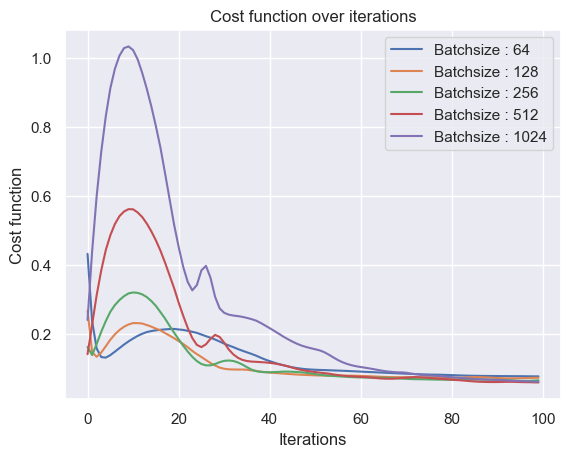

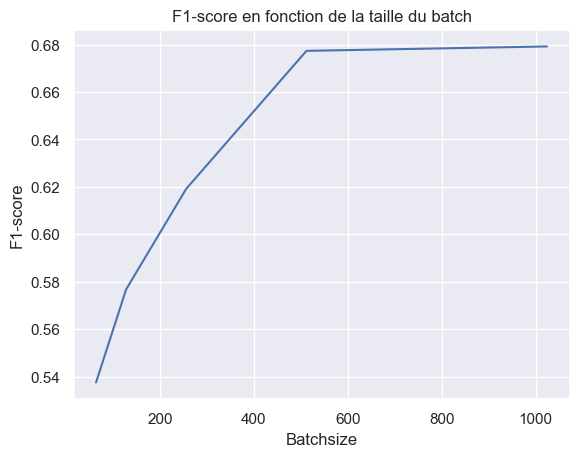

In [12]:
#TODO : Study the loss & accuracy for different batchsizes
lambd = 0.01
penalty = "l2"
lr = 1e-2
batchsizes = [64, 128, 256, 512, 1024]
opt = "Momentum"
gamma = 0.999
beta = 0.9
eps = 1e-8
debias = False
thresh = 0.2
calculate_cost = True

courbes_costs = []
accuracies = []

for batchsize in tqdm(batchsizes):
    SBD_logreg = StochasticLogisticRegression(
        lambd=lambd,
        penalty=penalty,
        lr=lr,
        batchsize=batchsize,
        opt=opt,
        gamma=gamma,
        beta=beta,
        eps=eps,
        debias=debias,
        thresh=thresh,
        calculate_cost=calculate_cost,
    )
    SBD_logreg.fit(X_train, y_train, max_iter=100)
    courbes_costs.append(SBD_logreg.f_history_)
    accuracies.append(SBD_logreg.accuracy_evaluation(X_test,y_test,thresh=0.2,margin=0,vizualisation=False)['F1_score'])

# Plot costs
for i, courbe in enumerate(courbes_costs):
    plt.plot(list(range(len(courbe))), courbe, label=f"Batchsize : {batchsizes[i]}")
plt.xlabel("Iterations")
plt.ylabel("Cost function")
plt.title("Cost function over iterations")
plt.legend()
plt.show()

# Plot F1-scores
plt.plot(batchsizes, accuracies)
plt.xlabel("Batchsize")
plt.ylabel("F1-score")
plt.title("F1-score en fonction de la taille du batch")
plt.show()

## Gamma impact

100%|██████████| 10/10 [01:47<00:00, 10.74s/it]


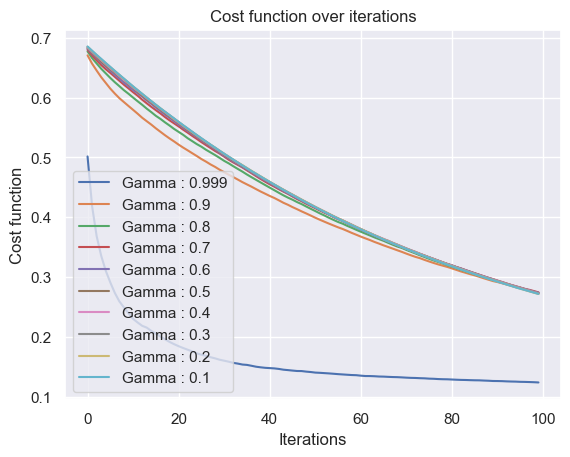

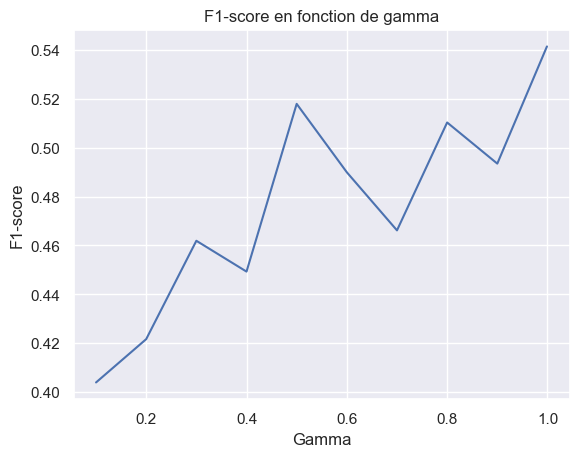

In [13]:
#TODO : Study Loss and F1-score
lambd = 0.01
penalty = "l2"
lr = 1e-2
batchsize = 64
opt = "RMSprop"
gammas = [0.999, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
beta = 0.9
eps = 1e-8
debias = False
thresh = 0.1

courbes_costs_gammas = []
f1_scores_gammas = []

for gamma in tqdm(gammas):
    SBD_logreg = StochasticLogisticRegression(
        lambd=lambd,
        penalty=penalty,
        lr=lr,
        batchsize=batchsize,
        opt=opt,
        gamma=gamma,
        beta=beta,
        eps=eps,
        debias=debias,
        thresh=thresh,
        calculate_cost=True,
    )
    SBD_logreg.fit(X_train, y_train, max_iter=100)
    courbes_costs_gammas.append(SBD_logreg.f_history_)
    SBD_logreg = StochasticLogisticRegression(
        lambd=lambd,
        penalty=penalty,
        lr=lr,
        batchsize=batchsize,
        opt=opt,
        gamma=gamma,
        beta=beta,
        eps=eps,
        debias=debias,
        thresh=thresh,
        calculate_cost=False,
    )
    SBD_logreg.fit(X_train, y_train, max_iter=1000)
    f1_scores_gammas.append(SBD_logreg.accuracy_evaluation(X_test,y_test,thresh=0.1,margin=0,vizualisation=False)['F1_score'])

# Plot costs
for i, courbe in enumerate(courbes_costs_gammas):
    plt.plot(list(range(len(courbe))), courbe, label=f"Gamma : {gammas[i]}")
plt.xlabel("Iterations")
plt.ylabel("Cost function")
plt.title("Cost function over iterations")
plt.legend()
plt.show()

# Plot des F1-scores
plt.plot(gammas, f1_scores_gammas)
plt.xlabel("Gamma")
plt.ylabel("F1-score")
plt.title("F1-score en fonction de gamma")
plt.show()

## Beta impact
Nous allons comparer les paramètres beta pour gamma = 0.999 et batch_size=1024

  0%|          | 0/8 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [02:53<00:57, 28.77s/it]C:\Users\victo\AppData\Local\Temp\ipykernel_9112\2474428468.py:88: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
100%|██████████| 8/8 [03:48<00:00, 28.52s/it]


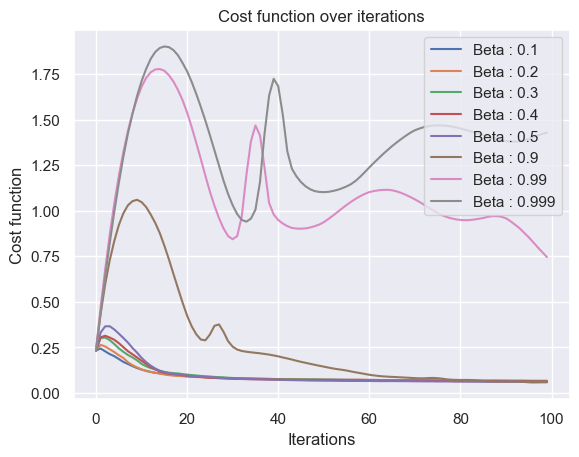

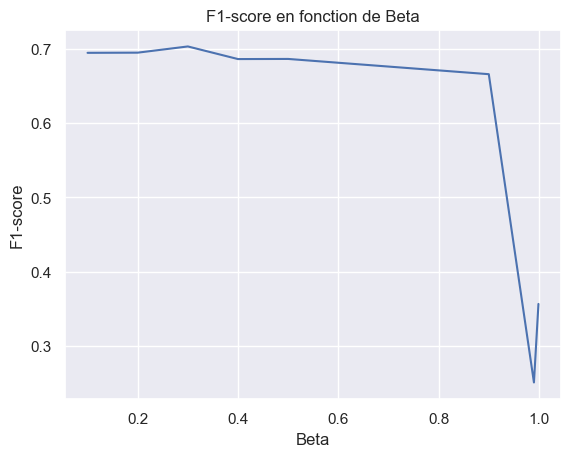

In [21]:
#TODO : Study Loss and F1-score
lambd = 0.01
penalty = "l2"
lr = 1e-2
batchsize = 1024
opt = "Momentum"
gamma = 0.999
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.9, 0.99, 0.999]
eps = 1e-8
debias = False
thresh = 0.1
calculate_cost = True

courbes_costs_betas = []
f1_scores_betas = []

for beta in tqdm(betas):
    SBD_logreg = StochasticLogisticRegression(
        lambd=lambd,
        penalty=penalty,
        lr=lr,
        batchsize=batchsize,
        opt=opt,
        gamma=gamma,
        beta=beta,
        eps=eps,
        debias=debias,
        thresh=thresh,
        calculate_cost=True,
    )
    SBD_logreg.fit(X_train, y_train, max_iter=100)
    courbes_costs_betas.append(SBD_logreg.f_history_)
    SBD_logreg = StochasticLogisticRegression(
        lambd=lambd,
        penalty=penalty,
        lr=lr,
        batchsize=batchsize,
        opt=opt,
        gamma=gamma,
        beta=beta,
        eps=eps,
        debias=debias,
        thresh=thresh,
        calculate_cost=False,
    )
    SBD_logreg.fit(X_train, y_train, max_iter=1000)
    f1_scores_betas.append(SBD_logreg.accuracy_evaluation(X_test,y_test,thresh=0.1,margin=0,vizualisation=False)['F1_score'])

# Plot costs
for i, courbe in enumerate(courbes_costs_betas):
    plt.plot(list(range(len(courbe))), courbe, label=f"Beta : {betas[i]}")
plt.xlabel("Iterations")
plt.ylabel("Cost function")
plt.title("Cost function over iterations")
plt.legend()
plt.show()

# Plot F1-scores
plt.plot(betas, f1_scores_betas)
plt.xlabel("Beta")
plt.ylabel("F1-score")
plt.title("F1-score en fonction de Beta")
plt.show()

# Best model

100%|██████████| 1000/1000 [00:18<00:00, 53.90it/s]


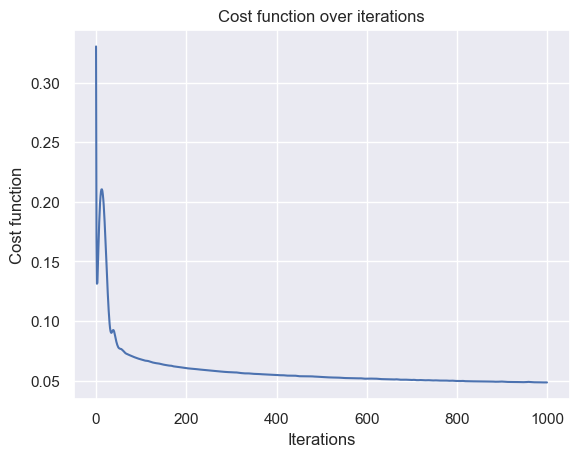

Accuracy : 0.9845291752954075
Precision : 0.8465346534653465
Recall : 0.6404494382022472
F1-score : 0.7292110874200426


In [15]:
lambd = 0.01
penalty = "l2"
lr = 1e-3
batchsize = 1024
opt = "Momentum"
gamma = 0.999
beta = 0.9
eps = 1e-8
debias = False
thresh = 0.3
calculate_cost = True

SBD_logreg = StochasticLogisticRegression(
    lambd=lambd,
    penalty=penalty,
    lr=lr,
    batchsize=batchsize,
    opt=opt,
    gamma=gamma,
    beta=beta,
    eps=eps,
    debias=debias,
    thresh=thresh,
    calculate_cost=calculate_cost,
)

SBD_logreg.fit(X_train, y_train, max_iter=1000)
SBD_logreg.plot_costs()
y_predict = SBD_logreg.predict(X_test)
print(f"Accuracy : {accuracy_score(y_test, y_predict)}")
print(f"Precision : {precision_score(y_test, y_predict)}")
print(f"Recall : {recall_score(y_test, y_predict)}")
print(f"F1-score : {f1_score(y_test, y_predict)}")

In [16]:
# Comparison with sklearn
from sklearn.linear_model import LogisticRegression
reg_log = LogisticRegression()
reg_log.fit(X_train, y_train)
y_predict = reg_log.predict(X_test)
print(f"Accuracy : {accuracy_score(y_test, y_predict)}")
print(f"Precision : {precision_score(y_test, y_predict)}")
print(f"Recall : {recall_score(y_test, y_predict)}")
print(f"F1-score : {f1_score(y_test, y_predict)}")

Accuracy : 0.9836764526738945
Precision : 0.8888888888888888
Recall : 0.5692883895131086
F1-score : 0.6940639269406392
